To download data from CGS sequencing center, at the SPEC-SEQ directory run<br>wget -r --no-parent 'url to download' <br>a new folder will be made each time in the 'files' subdirectory under htcf.wustl.edu directory

To parse fastq.gz file into fasta (seqtk documentation https://github.com/lh3/seqtk)<br>seqtk seq -a in.fq.gz > out.fa
 
 what the raw read looks like 
 CAACTACTGAGTACGTACCGAG 22 [TAACTT] 27 AGATCAGAGATGACTGCAGCAGATCGGAAGAGCACACGTCTGAACTCCAGTCACTTATCTCTCATCTCGTATGCCGTCTTCTGCTTGAAAAAAAAAAGGGGGGGGGGGGGGGGGGGGGGGGG
 source directory /mnt/v/yqzheng/qiaoer/VSCode_yiqiao/SPEC-SEQ/htcf.wustl.edu/files/xxxxxxx
 output directory /mnt/v/yqzheng/qiaoer/VSCode_yiqiao/SPEC-SEQ/xxxxxxx/extracted_fasta

 color map:0x009980, 0x59B3E6, 0xE69B04, 0x1A1A1

In [1]:
#setup the environment
import sys
import os
import itertools
import warnings
import glob2
import re

import pandas as pd
import numpy as np
from scipy import stats
import math

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns

In [2]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
# locally
# compatible naming between WinOS and MacOS
base_dir = os.getcwd()
# set the SPEC-SEQ parent directory as the working directory
os.chdir(base_dir)
sys.path.insert(0, os.path.join(os.path.dirname(base_dir) ,"utils"))
outbase_dir = os.path.join(base_dir, "processed_data")

In [7]:
sys.path

['/mnt/v/yqzheng/qiaoer/VSCode_yiqiao/SPEC-SEQ/scripts/utils',
 '/mnt/v/yqzheng/qiaoer/VSCode_yiqiao/SPEC-SEQ/cooperativity_mono_TAAT_pool4',
 '/home/qiaoerrrrr/miniconda3/envs/specseq/lib/python39.zip',
 '/home/qiaoerrrrr/miniconda3/envs/specseq/lib/python3.9',
 '/home/qiaoerrrrr/miniconda3/envs/specseq/lib/python3.9/lib-dynload',
 '',
 '/home/qiaoerrrrr/miniconda3/envs/specseq/lib/python3.9/site-packages']

In [4]:
from utils import specseq_ewm_utils, specseq_plot_utils, chipseq_plot_utils, specseq_predict_occp
specseq_plot_utils.set_manuscript_params()

In [6]:
div_heat_colors = mpl.colors.LinearSegmentedColormap.from_list(
                        "yq_divergent", [(0, "#CF8B03"), (0.5, "#FFFFFF"), (1, "#08306B")])
single_heat_colors = mpl.colors.LinearSegmentedColormap.from_list(
                        "yq_single", [(0, "#D5DCE6"), (1, "#08306B")])

ref_dict = pd.Series({"wt": ['TAATCC','GGATTA','TAATCCGGG','TAATGCTATTA',"TAATGCGCTATTA"],
            "e80a": ['TAATCC','GGATTA','TAATCCGGG','TAATGCTATTA',"TAATGCGCTATTA"],
            "k88n": ['TAATTA','TAATTA','TAATTAGGG',"TAATGCTATTA","TAATGCGCTATTA"], #p3 consensus is gtc 'TAATAATATTA','TAATAAGTTATTA'
            "r90w": ['TAATCC','GGATTA','TAATCCGGG','TAATGCTATTA',"TAATGCGCTATTA"]
            })

#### 0. reading in data
Preprocessing and quantification of Coop-seq libraries were performed identically as [Spec-seq](https://github.com/YiqiaoZHENG/CRXHD_mousemodel/tree/main/Specseq_analysis) in our previous publication.<br>
The counts per milion nomralized matrices were directly used for analysis in this script.

In [11]:
# comprehensive set of sequences
dimeric_cpm_ser = pd.Series(dtype=object)
for genotype, newname in zip(["wt","e","k","r"], ["wt", "e80a", "k88n", "r90w"]):
    for i in range(1,3):
        tmp = pd.read_csv(os.path.join(outbase_dir, "normalized_counts", f"{genotype}_{str(i)}_cpm.txt"), sep="\t", header=0).set_index("sequence")
        dimeric_cpm_ser[f"{newname}_{str(i)}"] = tmp
        del(tmp)

#### 1. check replicate correlation for each protein

In [9]:
# print the cpm replicate correlation plot - scatter
# for each sample pair, i have created a processed.txt in the format of
#sequence	lib	M.CPM	F.CPM
#TAAAAA	M	1042.9703796412182	3334.4764657611427
# by defualt, the seqeunces are sorted by nucleotide in pre-processing steps

def plot_scatter_from_pair_cpm(df1, df2, genotype, suffix="CPM", lr=True, show_stats=True, 
                                markers={'M':'^','Mrev':'s','P3TAAT':'X','P5TAAT':'o'},
                                color_map=['#009980','#59B3E6','#E69B04','#1A1A1A'],
                                sample_name=["Dimer band","Monomer band","Free band"],
                                legend_title="library", xlabel=None, ylabel=None,
                                figax=None, figName=None):

    df1=df1.copy()
    df2=df2.copy()

    if figax is not None:
        fig, ax_list = figax
        # I will need three axes, if not given exactly 3, create new
        if len(ax_list) != 3:
            fig, ax_list = plt.subplots(nrows=1, ncols=3, figsize=(5,2), dpi=150)
    else:
        fig, ax_list = plt.subplots(nrows=1, ncols=3, figsize=(5,2), dpi=150)

    # now go through the free band, monomer band, dimer band to and plot correlation
    for i, (band, ax) in enumerate(zip(["D","M","F"], ax_list)):
        # compile data from two dataframe
        data_to_plot = pd.merge(df1.loc[:,["lib", f"{band}.{suffix}"]].rename(columns={f"{band}.{suffix}":"sample1"}),
                                df2.loc[:, [f"{band}.{suffix}"]].rename(columns={f"{band}.{suffix}":"sample2"}),
                                how="inner", left_index=True, right_index=True)
        
        # also drop sequences that are not specified in the marker dictionary
        data_to_plot = data_to_plot.loc[data_to_plot.lib.isin(list(markers.keys())),:]

        ax = sns.scatterplot(data=data_to_plot, x='sample1', y='sample2', hue='lib', style='lib', ax=ax,
                             s=10, alpha=0.6, markers=markers, palette=color_map, hue_order=['M','Mrev','P3TAAT','P5TAAT'])
        # regression
        x=data_to_plot.sample1
        y=data_to_plot.sample2
        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        x_lin_reg = np.linspace(0, max(x), 100)
        y_lin_reg = slope*x_lin_reg+intercept

        # calculate Pearson correlation coefficient
        pearson_corr,_ = stats.pearsonr(x, y)
        # calculate Spearman rank correlation coefficient
        spearman_corr,_ = stats.spearmanr(x, y)

        # format disply text
        text = (f'r = {pearson_corr:.3f}', f'\u03C1 = {spearman_corr:.3f}', slope, intercept)

        if lr:
            # draw regression line
            #ax.plot(x_lin_reg, y_lin_reg, '--', linewidth=1, color="orange", alpha=0.8)
            # draw identity line
            ax.plot(x_lin_reg, x_lin_reg, '--', linewidth=1, color="grey", alpha=0.8)

        if show_stats:
            ax.text(x=.05, y=.95, s=f"$\it r$ = {pearson_corr:.3f}\n$\it \u03C1$ = {spearman_corr:.3f}", #\n$\it m$ = {slope:.3f}",
                    horizontalalignment='left',
                    verticalalignment='top', 
                    transform=ax.transAxes)

        # clean up
            ax.set(xlabel=f"Rep1 {suffix}", ylabel=f"Rep2 {suffix}")
            if sample_name is not None:
                ax.set_title(f"{str.upper(genotype)} HD {sample_name[i]}")
            ax.set_aspect("equal")
            ax.get_legend().remove()
            ax.ticklabel_format(axis="both", style="sci", useMathText=True) #??? it does not seem to work, why

    # add a single customized legend at the right most position of the plot
    if legend_title is None:
        legend_title = ""
    legend_elements = [mpl.lines.Line2D([0], [0], marker='o', color=color, label=label, lw=0, 
                                        markersize=3) for label,color in zip(list(markers.keys()), color_map)]
    ax_list[-1].legend(handles=legend_elements, loc=(1.02,0), frameon=False, title=legend_title)

    fig.tight_layout()

    if figName is not None:
        figname = os.path.join(outbase_dir, "figures", "rep_corr_scatter", figName)
    else:
        figname = figName

    return fig, ax_list, figname, text

Will save figure to: /scratch/sclab/cooperativity_mono_TAAT_pool4/figures/rep_corr_scatter/wt_allSequences_cpm
Will save figure to: /scratch/sclab/cooperativity_mono_TAAT_pool4/figures/rep_corr_scatter/e80a_allSequences_cpm
Will save figure to: /scratch/sclab/cooperativity_mono_TAAT_pool4/figures/rep_corr_scatter/k88n_allSequences_cpm
Will save figure to: /scratch/sclab/cooperativity_mono_TAAT_pool4/figures/rep_corr_scatter/r90w_allSequences_cpm


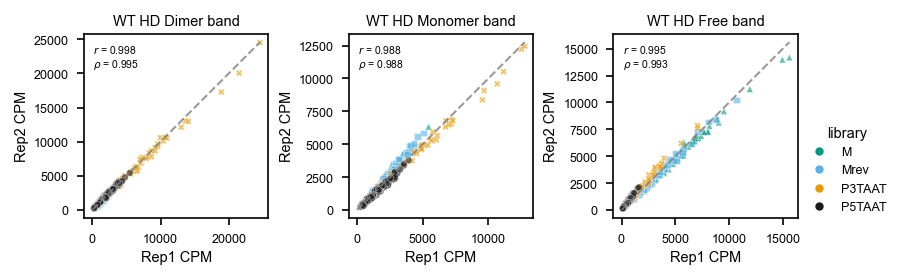

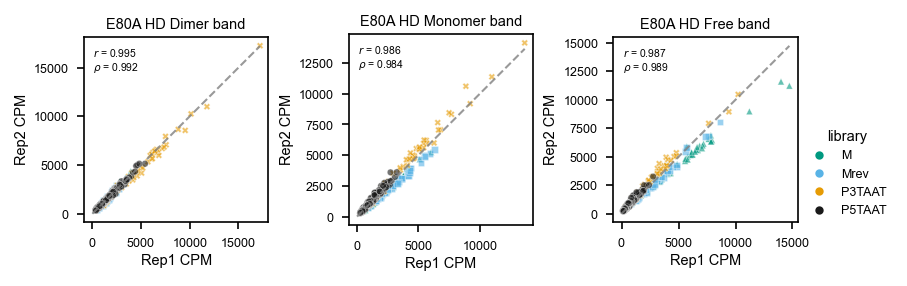

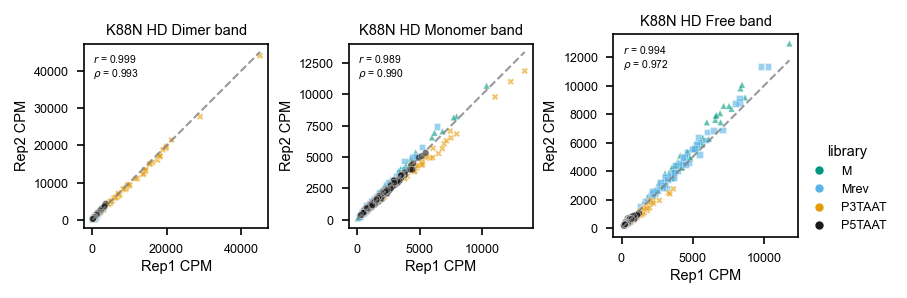

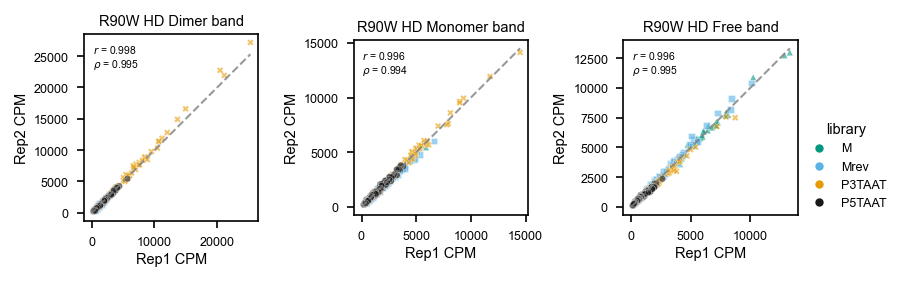

In [200]:
for geno in ["wt","e80a","k88n","r90w"]:
    fig, ax_list = plt.subplots(nrows=1, ncols=3, figsize=(6,2), dpi=150)
    fig, ax_list, figname, text = plot_scatter_from_pair_cpm(dimeric_cpm_ser[f"{geno}_1"],dimeric_cpm_ser[f"{geno}_2"],
                                                            genotype=geno,
                                                            figax=(fig, ax_list), figName=f"{str.lower(geno)}_allSequences_cpm")
    print(f"Will save figure to: {figname}")

    #fig.savefig(f"{figname}.png", dpi=300, bbox_inches="tight")
    #specseq_plot_utils.save_fig(fig, figname, timestamp=False, tight_layout=False)


#### 2. calculate count ratios of sequences in the dimeric, monomeric, and free bands

In [43]:
def _count_mismatches(query, reference_list):
    # query should be a list of sequence-lib pair
    # and reference list contains the four reference sequences corresponding to M, Mrev, P3, P5 libraries
    if len(reference_list) == 4:
        reference_lib = {k:v for k,v in zip(['M','Mrev','P3TAAT','P5TAAT'], reference_list)}
    else:
        reference_lib = {k:v for k,v in zip(['M','Mrev','MGGG','P3TAAT','P5TAAT'], reference_list)}
    motif_lib = query.to_dict()
    for seq,lib in motif_lib.items():
        ref=reference_lib[lib]
        # count mismatches to the reference
        motif_lib[seq]=sum(a!=b for a,b in zip(seq,ref))
    
    # a new dataframe containing only the mismatch counts for all sequences
    new_df = pd.DataFrame({'MMcount':motif_lib}).rename_axis('sequence')

    # an updated dataframe containing both the input query and the mismatch counts for all sequences
    sum_df = pd.merge(query, new_df, left_index=True, right_index=True).drop(columns="lib")

    return sum_df

In [44]:

def calculate_ratio_fromRawCounts(raw_df,reference_list,core_motif=False):
    raw_df = raw_df.copy()

    # count mismatches to the given reference sequences
    normalized_df = _count_mismatches(raw_df.loc[:,"lib"], reference_list)
    normalized_df = pd.merge(normalized_df, raw_df, left_index=True, right_index=True)
    
    # fill in 'n.a.' with 0
    normalized_df['D.CPM'] = normalized_df['D.CPM'].fillna(0)
    #caculate ratios
    normalized_df['m.u'] = (normalized_df['M.CPM']/normalized_df['F.CPM'])
    normalized_df['d.u'] = (normalized_df['D.CPM']/normalized_df['F.CPM'])

    # adjust for TAATTA (palindrome by itself)
    normalized_df.loc['TAATTA','m.u']=float(normalized_df.loc['TAATTA','m.u'])/2

    # specify order of columns
    if core_motif or len(reference_list)==4:
        lib_order = ["M","Mrev"]*2 + ["P3","P5"]*2
        band_order = ["m.u"]*2 + ["d.u"]*2 + ["m.u"]*2 + ["d.u"]*2 
        ref_order = reference_list[0:2]*2 + reference_list[2:]*2
    else:
        lib_order = ["M","Mrev","MGGG"]*2 + ["P3","P5"]*2
        band_order = ["m.u"]*3 + ["d.u"]*3 + ["m.u"]*2 + ["d.u"]*2 
        ref_order = reference_list[0:3]*2 + reference_list[3:]*2

    for lib,band,reference in zip(lib_order, band_order, ref_order):
        # retreive ratio for the reference sequence
        ref_count = normalized_df.loc[reference,band]
        # normalize all ratios to the corresponding reference sequences in M, Mrev, MGGG, P3, P5 libraries
        normalized_df[f'{lib}ref{band}'] = normalized_df[band]/ref_count
    
    # calculate du/mm, note this value should only be used on palindrome sequences where Mx approximates Mx'
    normalized_df['du.mm']=normalized_df['D.CPM']*normalized_df['F.CPM']/(normalized_df['M.CPM']*normalized_df['M.CPM'])*0.25

    return normalized_df

In [45]:
# calculate ratios and output to file
dimeric_ratio_ser = pd.Series(dtype=object)
for sample in dimeric_cpm_ser.index:
    outFileName = os.path.join(outbase_dir, "ratios", f"{str.lower(sample)}_ratios.tsv")
    normalized_df = calculate_ratio_fromRawCounts(dimeric_cpm_ser[sample], ref_dict[str.split(sample, "_")[0]], core_motif=False)
    # write to file
    normalized_df.to_csv(outFileName, sep="\t", index=True, header=True)
    # save to dictionary
    dimeric_ratio_ser[sample] = normalized_df


In [62]:
def average_ratios(samples, indir, outdir): # should i write a >2 replicate function??
    for sample in samples:
      allRepDf = glob2.glob(os.path.join(indir, f"{sample}*.tsv"))
    
      # read in raw count and m/u data, and create a new entry for TAATTA Mrev
      df1 = pd.read_csv(allRepDf[0], sep='\t', header=0, index_col='sequence')
      df2 = pd.read_csv(allRepDf[1], sep='\t', header=0, index_col='sequence')
      
      df_combined=df1.loc[:,['lib','MMcount']]
      for column in ['Mrefm.u','Mrevrefm.u','MGGGrefm.u','Mrefd.u','Mrevrefd.u','MGGGrefd.u','P3refm.u','P5refm.u','P3refd.u','P5refd.u','du.mm']:
          if column in df1.columns:
              # calculate the average relative binding energy relative the reference sequences
              df_combined[column]=(df1[column]+df2[column])/2

      new_filename = os.path.join(outdir, f"{sample}_avg_ratios.tsv")
      df_combined.to_csv(new_filename, sep='\t')
      print(f"Writing average ratios to {new_filename}")
    
    return

In [ ]:
average_ratios(["wt","e80a","r90w","k88n"],
              indir=os.path.join(outbase_dir, "ratios"),
              outdir=os.path.join(outbase_dir, "ratios"))

#### 3. calculate relative cooperativity index

In [75]:
def calculate_cooperativity_omega(ratio_file,dimer_reference,lib_name='P5'):
    # read data, use average ratios
    data=pd.read_csv(ratio_file,sep='\t')
    protein=os.path.split(ratio_file)[1].split('_')[0]
    #print(protein)

    # retrieve dimer library data
    data_dimer=data.loc[(data['lib'].map(lambda x: x=='P5TAAT'))|(data['lib'].map(lambda x: x=='P3TAAT')),['sequence','lib','MMcount',f'{lib_name}refm.u',f'{lib_name}refd.u','du.mm']]
    # normalize to the same palindromic reference for all genotypes
    data_dimer[f'{lib_name}refm.u'] = data_dimer[[f'{lib_name}refm.u']]/(float(data_dimer.loc[data_dimer['sequence']==dimer_reference,f'{lib_name}refm.u'].values))
    
    # extract only p5 library palindrome m/u data and store them in ref_map
    complement = {'A':'T', 'T':'A', 'C':'G', 'G':'C'}
    ref_map=data_dimer.loc[(data_dimer['lib']=='P5TAAT') & (data_dimer['sequence'].map(lambda seq: seq[4:6]==''.join(complement.get(base, base) for base in reversed(seq[-6:-4])))),['sequence',f'{lib_name}refm.u']].reset_index(drop=True)
    
    # since all sequences are palindromic, use only forward halfsite as index
    ref_map['halfsite']=ref_map['sequence'].map(lambda seq: seq[0:6])
    
    ref_map=ref_map.set_index('halfsite').rename(columns={f'{lib_name}refm.u':'pred.m.u'})    
    
    # for a dimeric sequence in the monomer band, its m/u relates to the sum of Kx and Kx' - equ(4)
    # separately retrieve half site relative affinity from ref_map
    data_dimer['f.m.u']=data_dimer['sequence'].map(lambda seq: ref_map.loc[seq[0:6],'pred.m.u'])/2
    data_dimer['r.m.u']=data_dimer['sequence'].map(lambda seq: ref_map.loc[''.join(complement.get(base, base) for base in reversed(seq[-6:])),'pred.m.u'])/2

    # and calculate omega using predicted values - note this value should only be used for palindromic sequences
    data_dimer[lib_name+'.omega']=data_dimer['du.mm']*(data_dimer['f.m.u']+data_dimer['r.m.u'])*(data_dimer['f.m.u']+data_dimer['r.m.u'])/(data_dimer['f.m.u']*data_dimer['r.m.u'])
    
    ref_du = float(data_dimer.loc[data_dimer['sequence']==dimer_reference,f'{lib_name}refd.u'].values)
    ref_omega = float(data_dimer.loc[data_dimer['sequence']==dimer_reference,lib_name+'.omega'].values)
    ref_for = float(data_dimer.loc[data_dimer['sequence']==dimer_reference,'f.m.u'].values)
    ref_rev = float(data_dimer.loc[data_dimer['sequence']==dimer_reference,'r.m.u'].values)
    
    data_dimer[lib_name+'.norm.omega']=(data_dimer[f'{lib_name}refd.u']/(data_dimer['f.m.u']*data_dimer['r.m.u']))/(ref_du/(ref_for*ref_rev)) #equation 7 Omega(x)/Omega(y)
    data_dimer[lib_name+'.abs.omega']=data_dimer[lib_name+'.norm.omega']*ref_omega
    data_dimer['x+y/xy']=data_dimer[lib_name+'.omega']/data_dimer['du.mm']# i think i was curious how far this is from the palindrome where it is exactly 4
    
    return data_dimer

    

In [76]:
cooperativity_ser = pd.Series(dtype=object)

for genotype in ["wt","e80a","k88n","r90w"]:
    outdir=os.path.join(outbase_dir, "ratios")
    # use perfect palindromic P5 sequences as reference, half site kd = 1/2 full site kd
    data_dimer = calculate_cooperativity_omega(os.path.join(outdir,f"{genotype}_avg_ratios.tsv"),
                                                                dimer_reference=ref_dict[genotype][-1], #TAATCGGCGATTA	 ref_dict[genotype][-1]
                                                                lib_name="P5")

    new_filename = os.path.join(outbase_dir, "cooperativity", f"{genotype}_cooperativity.tsv")
    data_dimer.to_csv(new_filename, sep='\t',index=False, header=True)

    cooperativity_ser[genotype] = data_dimer

#### 4. check if using P5 palindromic sequence to model Kx and Kx' provides a good fit

rho: 0.6683670494003231 r: 0.7089982134034559


rho: 0.8394866337903608 r: 0.8422015239376328
rho: 0.58163218275923 r: 0.5859033731234027
rho: 0.860109223283462 r: 0.8771509356656975


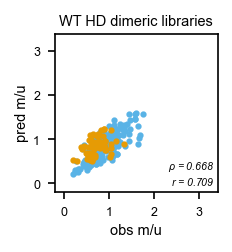

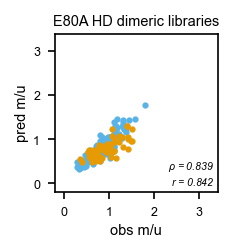

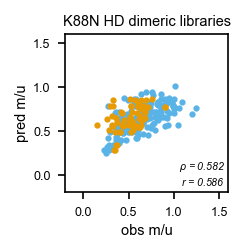

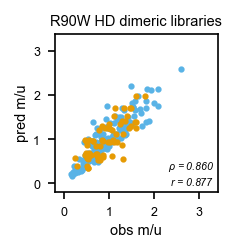

In [81]:
for genotype in cooperativity_ser.index:
    
    data_to_plot = cooperativity_ser[genotype].copy()
    data_to_plot["pred.m.u."] = data_to_plot["f.m.u"] + data_to_plot["r.m.u"]

    # palindromic only
    #data_to_plot = data_to_plot[data_to_plot["f.m.u"] == data_to_plot["r.m.u"]]

    # limit the MM count
    data_to_plot = data_to_plot[data_to_plot["MMcount"] <= 3]

    # regression
    res = stats.spearmanr(data_to_plot["P5refm.u"],data_to_plot["pred.m.u."])
    #rho_stats = res.correlation # htcf
    rho_stats = res[0] # xps
    
    res = stats.pearsonr(data_to_plot["P5refm.u"],data_to_plot["pred.m.u."])
    #r_stats = res.correlation # htcf
    r_stats = res[0] # xps
    
    print(f"rho: {rho_stats} r: {r_stats}")

    # overlapping histogram
    fig,ax=plt.subplots(figsize=(1.4,1.4), dpi=150)
    if genotype == "k88n":
        ax.set_xlim(-.2,1.6)
        ax.set_ylim(-.2,1.6)
    else:
        ax.set_xlim(-.2,3.4)
        ax.set_ylim(-.2,3.4)
    for library,color in zip(["P5TAAT","P3TAAT"],["#59B3E6","#E69B04",]):
        tmp = data_to_plot.loc[data_to_plot.lib==library,:]
        ax.scatter(tmp["P5refm.u"],tmp["pred.m.u."],marker='o',color=color, s=4)
    ax.set(title=f"{str.upper(genotype)} HD dimeric libraries", xlabel="obs m/u", ylabel="pred m/u")
    ax.text(.98,0.03,
            r"$\rho$"+" = {:.3f}\n".format(rho_stats)+r"$r$"+" = {:.3f}".format(r_stats),
            ha='right', va='bottom', style = 'italic',
               transform=ax.transAxes
        
    )
    
    ax.set_aspect("auto")

    fig.savefig(os.path.join(outbase_dir, "figures", "Kx_model", f"{genotype}_P5palindromic_predictMU_vs_observeMU.png"), dpi=300, bbox_inches="tight")

- i think the problem with modeling K88N data is that some sequences have a third motif spanning the spacer that are of higher affinity than one of the half site or a P3 spacer creates competition for monomer binding so that almost all the datapoints are about the diagnol

#### 5. distribution histogram of calculated relative cooperativity index

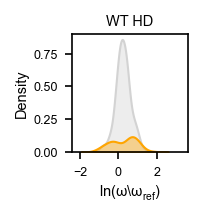

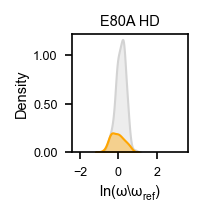

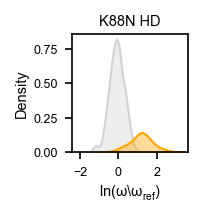

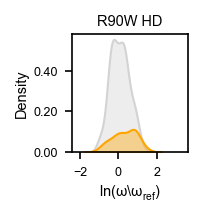

In [35]:
# distribution of omega calcualted from du/mm
for genotype in cooperativity_ser.index:
    data_to_plot = cooperativity_ser[genotype].copy()
    lib_name = "P5"

    # overlapping histogram
    fig,ax=plt.subplots(figsize=(1.3,1.4), dpi=150)

    small_data=data_to_plot.loc[data_to_plot['lib'].isin(["P3TAAT","P5TAAT"])&(data_to_plot['MMcount']<=5),:].copy()
    small_data[f"{lib_name}.ln.omega"] = np.log(small_data[f"{lib_name}.norm.omega"])

    # note: xps15 mpra env does not have the most up-to-date seaborn to make this plot, use specseq or modeling envs
    ax = sns.kdeplot(data=small_data, x="P5.ln.omega", hue="lib",
                    palette=["orange","lightgray"], fill=True, 
                    alpha=.4, legend=False, ax=ax)
    ax.set_title(f"{str.upper(genotype)} HD")
    ax.set_xlabel("ln(\u03C9\\\u03C9$_{ref}$)") # P5.norm.omega

    # decorations
    #sns.move_legend(ax, title="", loc="upper left", bbox_to_anchor=(1,1), frameon=False)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_xlim(-2.4,3.6)
    ax.set_aspect("auto")

    plt.tight_layout()

    #fig.savefig(os.path.join(outbase_dir, "figures", "omega", f"{genotype}_normedHistogram_AllSequences.png"), dpi=300, bbox_inches="tight")


#### 6. visualize P3 mediated cooperative dimerzation

In [ ]:
# match each p3 sequence with its p5 counterpart
all_genotype_p3p5_coop_df = pd.DataFrame(index=cooperativity_ser["wt"].loc[lambda df:df.lib=="P3TAAT","sequence"].values)

for genotype in cooperativity_ser.index: 
    genotype_df = pd.read_csv(os.path.join(outbase_dir, "cooperativity", f"{genotype}_p3p5_matched_cooperativity.tsv"), sep="\t", header=0).set_index("sequence")
    genotype_df["delta.ln.omega"] = genotype_df["p3.ln.omega"] - genotype_df["p5.ln.omega"] # same as rev.aff in the old dataframe
    genotype_df = genotype_df[["p3.ln.omega","p5.ln.omega","delta.ln.omega"]].rename(columns={k:f"{genotype}.{k}" for k in genotype_df.columns})

    all_genotype_p3p5_coop_df = all_genotype_p3p5_coop_df.merge(genotype_df, left_index=True, right_index=True, how="left")

all_genotype_p3p5_coop_df.index.name = "sequence"

In [434]:
all_genotype_p3p5_coop_df.to_csv(os.path.join(outbase_dir, f"allgenotypes_p3p5_matched_cooperativity.tsv"), sep="\t", header=True, index=True)

In [7]:
all_genotype_p3p5_coop_df = pd.read_csv(os.path.join(outbase_dir, f"allgenotypes_p3p5_matched_cooperativity.tsv"), sep="\t", header=0)
all_genotype_p3p5_coop_df = all_genotype_p3p5_coop_df.rename(columns={all_genotype_p3p5_coop_df.columns[0]:"sequence"}).set_index("sequence")

In [12]:
cooperativity_ser = pd.Series()
for genotype in ["wt","e80a","k88n","r90w"]:
    genotype_df = pd.read_csv(os.path.join(outbase_dir, "cooperativity", f"{genotype}_cooperativity.tsv"), sep="\t", header=0).set_index("sequence")
    cooperativity_ser[genotype] = genotype_df

del(genotype_df)

found BAT1


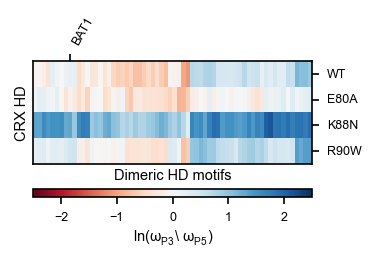

In [12]:
# Panel 4a. sample wise correlation heatmap
fig, ax = plt.subplots(figsize=(2.4,1.2), dpi=150)

vmin=-2.5
vmax=2.5
thresh = 1
# reorder the PCC dataframe
data_to_plot = all_genotype_p3p5_coop_df.loc[:,lambda df: df.columns[df.columns.str.contains("delta")]].copy()

# clustering
reponsive_CRE_to_plot_cg = chipseq_plot_utils.chip_intensity_heatmap(data=data_to_plot, #.loc[:,lambda df: df.columns[~df.columns.str.contains("r90w")]],  
                                                                        hm_title=None, hm_xlabel=None, cb_title=None, cmap=div_heat_colors, 
                                                                        paramdict=dict(
                                                                        z_score=None,
                                                                        method="complete",
                                                                        metric="euclidean",
                                                                        #method="ward",
                                                                        #metric="correlation"
                                                                    ))
new_order = reponsive_CRE_to_plot_cg.dendrogram_row.reordered_ind
plt.close()
# reorder the differential expression dataframe based on clustering
data_to_plot = data_to_plot.iloc[new_order,:].iloc[::-1].T #

# rank by one hd
#data_to_plot = data_to_plot.sort_values(by="k88n.delta.ln.omega", ascending=True).T

heatmap = ax.imshow(data_to_plot, aspect="auto", vmin=vmin, vmax=vmax, cmap="RdBu")
ax.xaxis.tick_top() 
#ax.set_xticks(np.arange(len(data_to_plot.columns)))
#ax.set_xticklabels(data_to_plot.columns, rotation=90, ha="center")
ax.set_xticks([])
# annotate only the BAT1 column
for i,seq in enumerate(data_to_plot.columns):
   if seq == "TAATCATATTA":
       print("found BAT1")
       ax.set_xticks([i],["BAT1"], rotation=60, ha="left")
       break

ax.yaxis.tick_right()
ax.set_yticks(np.arange(len(data_to_plot.index)))
ax.set_yticklabels(["WT", "E80A", "K88N", "R90W"], va="center")
ax.set_xlabel(f"Dimeric HD motifs")
ax.set_ylabel(f"CRX HD")

#specseq_plot_utils.annotate_heatmap(ax, data_to_plot.T, thresh)

# Add a colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="8%", pad="24%")
colorbar = fig.colorbar(heatmap, cax=cax, orientation="horizontal", label="ln(\u03C9$_{P3}$\\ \u03C9$_{P5}$)")

fig.savefig(os.path.join(outbase_dir, "figures", "omega", f"allgenotypes_p3p5_delta_heatmap.png"), dpi=600, bbox_inches="tight")
fig.savefig(os.path.join(outbase_dir, "figures", "omega", f"allgenotypes_p3p5_delta_heatmap.svg"), dpi=600, bbox_inches="tight")


found BAT1


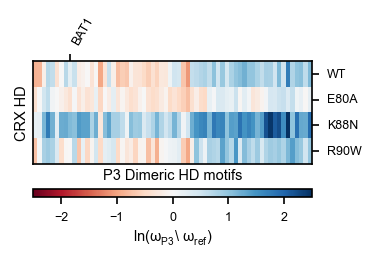

In [13]:
# Panel 4a. sample wise correlation heatmap
fig, ax = plt.subplots(figsize=(2.4,1.2), dpi=150)

thresh = 1
# reorder the PCC dataframe
data_to_plot = all_genotype_p3p5_coop_df.loc[:,lambda df: df.columns[df.columns.str.contains("p3")]].copy()

# clustering
#reponsive_CRE_to_plot_cg = chipseq_plot_utils.chip_intensity_heatmap(data=data_to_plot, #.loc[:,lambda df: df.columns[~df.columns.str.contains("r90w")]],  
#                                                                        hm_title=None, hm_xlabel=None, cb_title=None, cmap=div_heat_colors, 
#                                                                        paramdict=dict(
#                                                                        z_score=None,
#                                                                        method="complete",
#                                                                        metric="euclidean",
#                                                                        #method="ward",
#                                                                        #metric="correlation"
#                                                                   ))
#new_order = reponsive_CRE_to_plot_cg.dendrogram_row.reordered_ind
#plt.close()
# reorder the differential expression dataframe based on clustering
data_to_plot = data_to_plot.iloc[new_order,:].iloc[::-1].T #

heatmap = ax.imshow(data_to_plot, aspect="auto", vmin=vmin, vmax=vmax, cmap="RdBu")
ax.xaxis.tick_top() 
#ax.set_xticks(np.arange(len(data_to_plot.columns)))
#ax.set_xticklabels(data_to_plot.columns, rotation=90, ha="center")
ax.set_xticks([])
# annotate only the BAT1 column
for i,seq in enumerate(data_to_plot.columns):
   if seq == "TAATCATATTA":
       print("found BAT1")
       ax.set_xticks([i],["BAT1"], rotation=60, ha="left")
       break
ax.yaxis.tick_right()
ax.set_yticks(np.arange(len(data_to_plot.index)))
ax.set_yticklabels(["WT", "E80A", "K88N", "R90W"], va="center")
ax.set_xlabel(f"P3 Dimeric HD motifs")
ax.set_ylabel(f"CRX HD")

#specseq_plot_utils.annotate_heatmap(ax, data_to_plot.T, thresh)

# Add a colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="8%", pad="24%")
colorbar = fig.colorbar(heatmap, cax=cax, orientation="horizontal", label="ln(\u03C9$_{P3}$\\ \u03C9$_{ref}$)")

fig.savefig(os.path.join(outbase_dir, "figures", "omega", f"allgenotypes_p3_omega_heatmap.png"), dpi=600, bbox_inches="tight")
fig.savefig(os.path.join(outbase_dir, "figures", "omega", f"allgenotypes_p3_omega_heatmap.svg"), dpi=600, bbox_inches="tight")


found BAT1


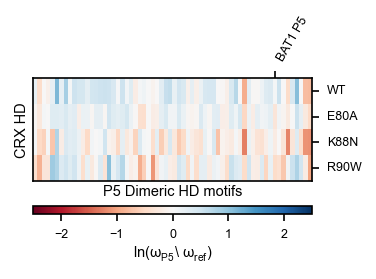

In [10]:
# Panel 4a. sample wise correlation heatmap
fig, ax = plt.subplots(figsize=(2.4,1.2), dpi=150)

thresh = 1
# reorder the PCC dataframe
data_to_plot = all_genotype_p3p5_coop_df.loc[:,lambda df: df.columns[df.columns.str.contains("p5")]].copy()

# clustering
#reponsive_CRE_to_plot_cg = chipseq_plot_utils.chip_intensity_heatmap(data=data_to_plot, #.loc[:,lambda df: df.columns[~df.columns.str.contains("r90w")]],  
#                                                                        hm_title=None, hm_xlabel=None, cb_title=None, cmap=div_heat_colors, 
#                                                                        paramdict=dict(
#                                                                        z_score=None,
#                                                                        method="complete",
#                                                                        metric="euclidean",
#                                                                        #method="ward",
#                                                                        #metric="correlation"
#                                                                    ))
#new_order = reponsive_CRE_to_plot_cg.dendrogram_row.reordered_ind
#plt.close()
# reorder the differential expression dataframe based on clustering
data_to_plot = data_to_plot.iloc[new_order,:].iloc[::-1].T #

heatmap = ax.imshow(data_to_plot, aspect="auto", vmin=vmin, vmax=vmax, cmap="RdBu")
ax.xaxis.tick_top() 
#ax.set_xticks(np.arange(len(data_to_plot.columns)))
#ax.set_xticklabels(data_to_plot.columns, rotation=90, ha="center")
ax.set_xticks([])
# annotate only the BAT1 column
for i,seq in enumerate(data_to_plot.columns):
   if seq == "TAATCATATTA":
       print("found BAT1")
       ax.set_xticks([i],["BAT1 P5"], rotation=60, ha="left")
       break
ax.yaxis.tick_right()
ax.set_yticks(np.arange(len(data_to_plot.index)))
ax.set_yticklabels(["WT", "E80A", "K88N", "R90W"], va="center")
ax.set_xlabel(f"P5 Dimeric HD motifs")
ax.set_ylabel(f"CRX HD")

#specseq_plot_utils.annotate_heatmap(ax, data_to_plot.T, thresh)

# Add a colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="8%", pad="24%")
colorbar = fig.colorbar(heatmap, cax=cax, orientation="horizontal", label="ln(\u03C9$_{P5}$\\ \u03C9$_{ref}$)")

fig.savefig(os.path.join(outbase_dir, "figures", f"allgenotypes_p5_omega_heatmap.png"), dpi=600, bbox_inches="tight")
fig.savefig(os.path.join(outbase_dir, "figures", f"allgenotypes_p5_omega_heatmap.svg"), dpi=600, bbox_inches="tight")
